# 2/15/20
_____
Основная проблема в том, что произведение эффективности регистрации на радпоправку не сходится при расчёте двух случаев: событий только с мягкими фотонами и всех событий

Эту проблему необходимо решать

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(rc={'figure.figsize':(13,7)}, font_scale=1.5)
plt.style.use('seaborn-whitegrid')

$$\varepsilon_{reg} (1+\delta) = \frac{N_{passed}}{N_{total}} (1+\delta)$$
Так как $N_{passed}$ одинаково для двух случаев, то его можно сократить и проверять следующее равенство:
$$\frac{(1+\delta_{all})}{N_{all\ total}} = \frac{(1+\delta_{soft})}{N_{soft\ total}} $$

Сначала построю картинку, которая у меня уже получилась

Проверка радпоправки на $\phi$-мезоне

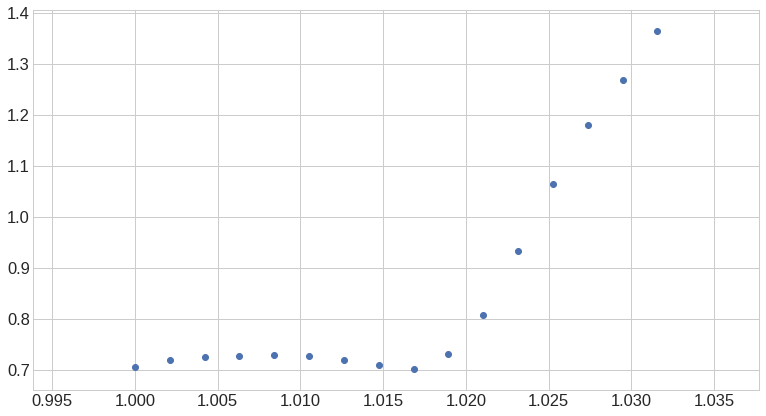

In [57]:
plt.scatter(data=rad_all.loc[:15], x='energy', y='radcor')
# plt.scatter(data=rad_soft.loc[:15], x='energy', y='radcor')

In [3]:
rad_soft = pd.read_csv('outputs/data/radcors_soft.dat', header=None, names=['energy', 'radcor']).sort_values(by='energy')
rad_all = pd.read_csv('outputs/data/radcors_all.dat', header=None, names=['energy', 'radcor']).sort_values(by='energy')

data = pd.read_csv('../../outputs/model_new_v6/soft_ph.csv').rename({'lum':'Nsoft'}, axis=1).assign(Nall=20000)

In [80]:
data.head()

,label,Nsoft,Nall
0,525.0,10422,20000
1,537.5,9010,20000
2,562.5,7484,20000
3,575.0,6947,20000
4,587.5,6527,20000


In [81]:
data['rad_soft'] = np.interp(data.label*2e-3, rad_soft.energy, rad_soft.radcor)
data['rad_all'] = np.interp(data.label*2e-3,  rad_all.energy, rad_all.radcor)
data['mult_soft'] = np.interp(data.label*2e-3, rad_soft.energy, rad_soft.radcor)/data.Nsoft
data['mult_all'] = np.interp(data.label*2e-3, rad_all.energy, rad_all.radcor)/data.Nall
data['mult_soft_err'] = data['mult_soft']/np.sqrt(data.Nsoft)
data['mult_all_err'] = data['mult_all']/np.sqrt(data.Nall)

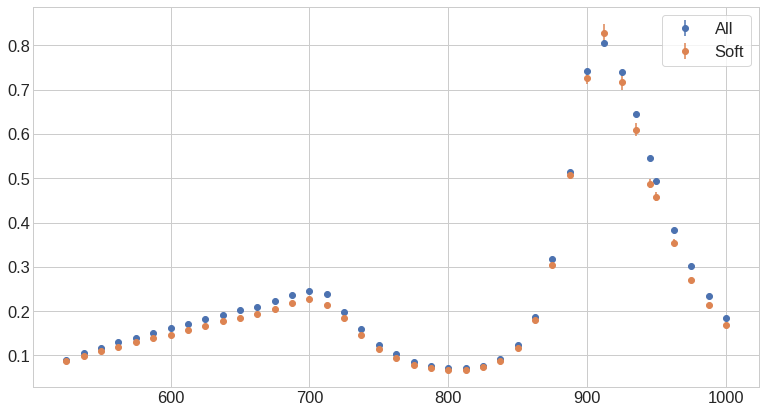

In [82]:
plt.errorbar(data.label, data.mult_all*1e3, yerr=data.mult_all_err*1e3, fmt='o', label='All')
plt.errorbar(data.label, data.mult_soft*1e3, yerr=data.mult_soft_err*1e3, fmt='o', label='Soft')
plt.legend(frameon=True);

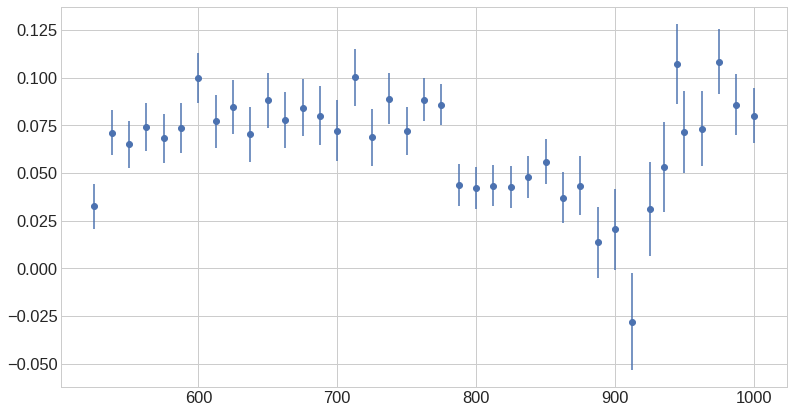

In [83]:
sub = (data.mult_all - data.mult_soft)/data.mult_all
sub_err = (data.mult_soft/data.mult_all)*np.sqrt( (data.mult_soft_err/data.mult_soft)**2 \
                                                 + (data.mult_all_err/data.mult_all)**2 )
plt.errorbar(data.label, sub, yerr=sub_err, fmt='o');

In [7]:
cs11a = pd.read_csv('../../outputs/cross_sections/vis_11_model_new_v6_all.csv')
cs11a['rad'] = np.interp(cs11a.Emean*2e-3, rad_all.energy, rad_all.radcor)
cs11a['mult'] = cs11a.rad*cs11a.RegEff
cs11a['mult_err'] = cs11a.rad*cs11a.RegErr
cs11a['CS'] /= cs11a['rad']
cs11a['dCS'] /= cs11a['rad']

cs11s = pd.read_csv('../../outputs/cross_sections/vis_11_model_new_v6_soft.csv')
cs11s['rad'] = np.interp(cs11s.Emean*2e-3, rad_soft.energy, rad_soft.radcor)
cs11s['mult'] = cs11s.rad*cs11s.RegEff
cs11s['mult_err'] = cs11s.rad*cs11s.RegErr
cs11s['CS'] /= cs11s['rad']
cs11s['dCS'] /= cs11s['rad']

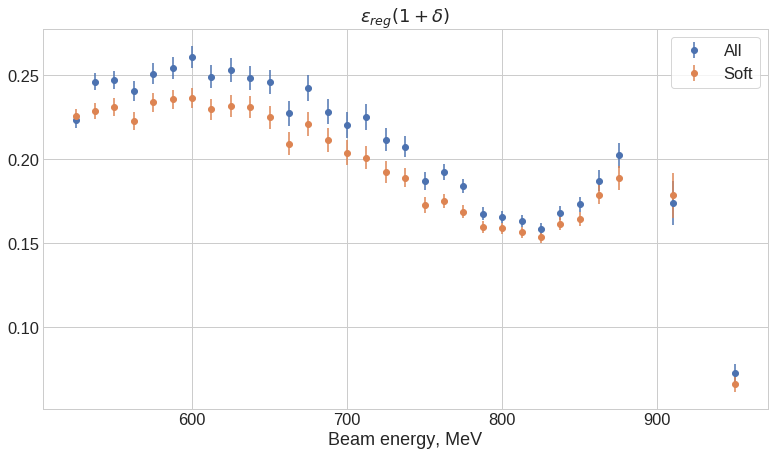

In [5]:
plt.errorbar(cs11a.name, cs11a.mult, yerr=cs11a.mult_err, fmt='o', label='All')
plt.errorbar(cs11s.name, cs11s.mult, yerr=cs11s.mult_err, fmt='o', label='Soft')
plt.title('$\\varepsilon_{reg}(1+\delta)$')
plt.xlabel('Beam energy, MeV')
plt.legend(frameon=True);

In [11]:
import iminuit

In [12]:
substr = (cs11a.CS - cs11s.CS)/cs11a.CS
substr_err = (cs11s.CS/cs11a.CS)*np.sqrt( (cs11a.dCS/cs11a.CS)**2 + (cs11s.dCS/cs11s.CS)**2 )

In [13]:
def least_squares(c):
    return np.sum((( substr - c ) / substr_err )**2 )

m = iminuit.Minuit(least_squares, c=1., error_c=0.01, errordef = 1)
m.migrad()

------------------------------------------------------------------
| FCN = 1.293                   |      Ncalls=15 (15 total)      |
| EDM = 1.5E-15 (Goal: 1E-05)   |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | c    |  -0.062   |   0.030   |            |            |         |         |       |
------------------------------------------------------------------------------------------

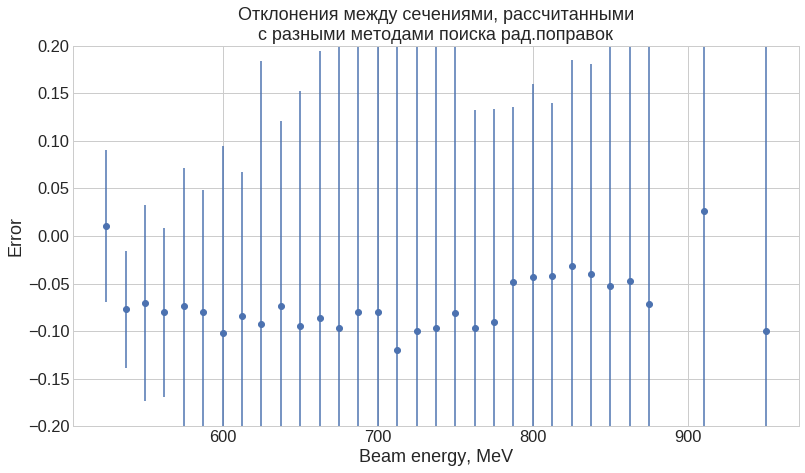

In [10]:
plt.errorbar(cs11a.name, substr , yerr=substr_err, fmt='o', label='');
plt.title('Отклонения между сечениями, рассчитанными\nс разными методами поиска рад.поправок');
plt.xlabel('Beam energy, MeV');
plt.ylim(-0.2, 0.2)
plt.ylabel('Error');

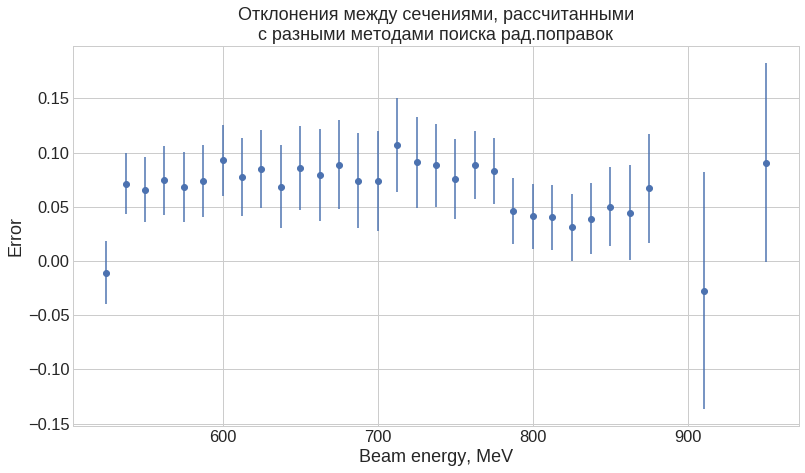

In [86]:
substr = (cs11a.mult - cs11s.mult)/cs11a.mult
substr_err = (cs11s.mult/cs11a.mult)*np.sqrt( (cs11a.mult_err/cs11a.mult)**2 + (cs11s.mult_err/cs11s.mult)**2 )
plt.errorbar(cs11a.name, substr , yerr=substr_err, fmt='o', label='');
plt.title('Отклонения между сечениями, рассчитанными\nс разными методами поиска рад.поправок');
plt.xlabel('Beam energy, MeV');
plt.ylabel('Error');

Систематическая разница между вариантами вычисления рад.поправки никуда не ушла

Есть гипотеза: дело в сверхмягких фотонах, т.к. они моделируются неведомым образом и непонятно как учитывать их вклад в рад.поправке

# 2/19/20

Проверяю гипотезу со сверхмягкими фотонами: вычисляю рад.поправку в нескольких случаях для разных $\Delta$

In [52]:
rads = dict()
for i in range(5, 10):
    rads[i] = pd.read_csv(f'outputs/data/radcors_delta_test/radcors_all_-{i}_delta.dat', header=None, 
                      names=['energy', f'radcor {i}'], index_col='energy')
r = pd.concat(rads.values(), axis=1)

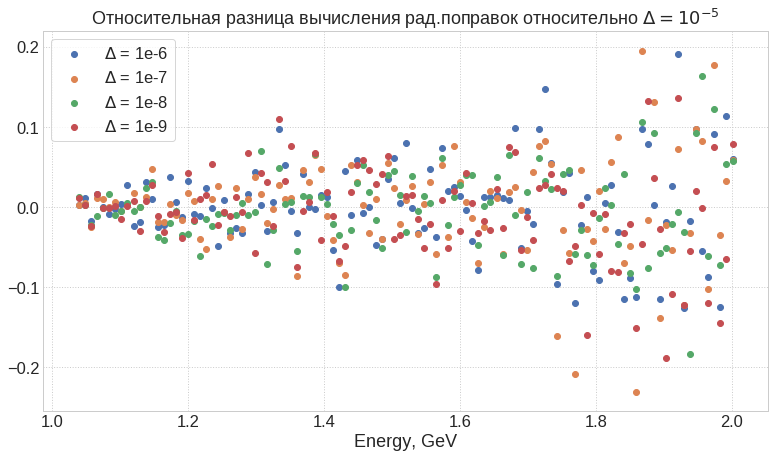

In [54]:
for i in range(6, 10):
    plt.scatter(r.index, (r[f'radcor {i}']-r['radcor 5'])/r['radcor 5'], label=f'$\Delta$ = 1e-{i}')
plt.title('Относительная разница вычисления рад.поправок относительно $\Delta = 10^{-5}$');
plt.xlabel('Energy, GeV');
plt.grid(linestyle=':')
plt.legend(frameon=True);
# plt.savefig('outputs/images/5_relative_delta.png', dpi=200)

**Вывод:** систематической разницы между вычислением рад.поправок с разными $\Delta$ не обнаружено 
***

Поиграю в будущем с радиаторами и интегрированием